In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, z):
        return self.fc(z)

In [4]:
# Generate S-curve dataset
data, labels = make_s_curve(n_samples=3000, noise=0.05, random_state=random_state)
data = torch.tensor(data, dtype=torch.float32).to(device)
labels = torch.tensor(labels, dtype=torch.float32)

val_data, val_labels = make_s_curve(n_samples=1000, noise=0.05, random_state=random_state+1)
val_data = torch.tensor(val_data, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_labels, dtype=torch.float32)

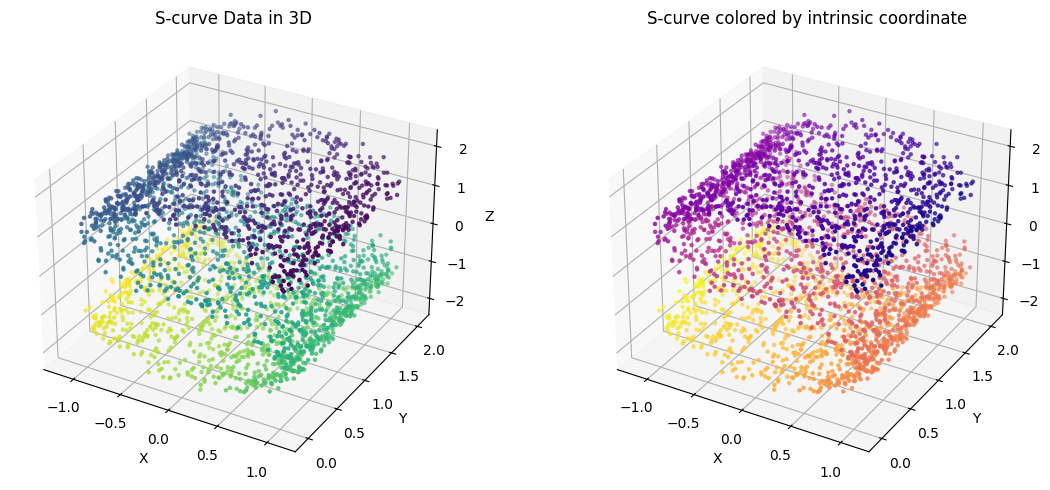

In [5]:
# Visualize the S-curve data
fig = plt.figure(figsize=(12, 5))

# 3D view
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(data[:, 0].cpu(), data[:, 1].cpu(), data[:, 2].cpu(), c=labels, s=5, cmap='viridis')
ax1.set_title("S-curve Data in 3D")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Color by intrinsic coordinate
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(data[:, 0].cpu(), data[:, 1].cpu(), data[:, 2].cpu(), c=labels, s=5, cmap='plasma')
ax2.set_title("S-curve colored by intrinsic coordinate")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [6]:
# Define model parameters
latent_dim = 2
input_dim = data.shape[1]  # 3 for S-curve
output_dim = data.shape[1]
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

dir_path = "models/conformal_autoencoder_cosine_comp_scurve"

In [7]:
# Lambda values for comparison
lambda_isos = np.logspace(-3, 2, 9)
lambda_isos = np.concatenate([np.zeros(1), lambda_isos])

In [8]:
from metrics import conformality_cosine_loss

In [9]:
import os

def modelpath(dir_path, lambda_iso, index):
    os.makedirs(dir_path, exist_ok=True)
    return f"{dir_path}/lambda_{lambda_iso:.3f}_model_{index+1}.pth"

In [10]:
num_epochs = 1000
# Train same model multiple times to average results
num_models = 4

recon_errors = []
regularization_errors = []
reg_metrics = []

for i, lambda_iso in enumerate(lambda_isos):
    recon_error = 0
    regularization = 0
    reg_metric = 0
    
    for j in range(num_models):
        print(f"Training model {j+1}/{num_models} with lambda_conf={lambda_iso:.3f}")
        
        encoder = Encoder(input_dim, latent_dim).to(device)
        decoder = Decoder(latent_dim, output_dim).to(device)
        model = ConformalAutoencoder(encoder, decoder, lambda_conf=lambda_iso).to(device)
        model.conformality_loss = conformality_cosine_loss

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

        # Train the model
        model.train_model(train_dataloader, val_dataloader, batch_size=batch_size, epochs=num_epochs,
                          optimizer=optimizer, scheduler=scheduler, verbose=False, log_every=200)

        # Save the model
        model_path = modelpath(dir_path, lambda_iso, j)
        model.save_checkpoint(model_path)
        print(f"Model {j+1}/{num_models} with lambda_conf={lambda_iso:.3f} trained and saved.")

        # Evaluation
        model.eval()
        with torch.no_grad():
            encoded_data = model.encode(val_data)
            reconstruction = model.decode(encoded_data)
            
            recon_error += nn.MSELoss()(reconstruction, val_data).item()
            regularization += model.conformality_loss(model.decoder, encoded_data).item()
            reg_metric += conformality_jacobian_loss(model.decoder, encoded_data).item()
    
    recon_errors.append(recon_error / num_models)
    regularization_errors.append(regularization / num_models)
    reg_metrics.append(reg_metric / num_models)
    
    print(f"Lambda {lambda_iso:.3f} completed - Recon: {recon_errors[-1]:.6f}, Reg: {regularization_errors[-1]:.6f}")

Training model 1/4 with lambda_conf=0.000


/home/maxheise/anaconda3/envs/ML/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Checkpoint saved to models/conformal_autoencoder_cosine_comp_scurve/lambda_0.000_model_1.pth at epoch 1001
Model 1/4 with lambda_conf=0.000 trained and saved.
Training model 2/4 with lambda_conf=0.000
Checkpoint saved to models/conformal_autoencoder_cosine_comp_scurve/lambda_0.000_model_2.pth at epoch 1001
Model 2/4 with lambda_conf=0.000 trained and saved.
Training model 3/4 with lambda_conf=0.000
Checkpoint saved to models/conformal_autoencoder_cosine_comp_scurve/lambda_0.000_model_3.pth at epoch 1001
Model 3/4 with lambda_conf=0.000 trained and saved.
Training model 4/4 with lambda_conf=0.000
Checkpoint saved to models/conformal_autoencoder_cosine_comp_scurve/lambda_0.000_model_4.pth at epoch 1001
Model 4/4 with lambda_conf=0.000 trained and saved.
Lambda 0.000 completed - Recon: 0.002454, Reg: 0.137625
Training model 1/4 with lambda_conf=0.001
Checkpoint saved to models/conformal_autoencoder_cosine_comp_scurve/lambda_0.001_model_1.pth at epoch 1001
Model 1/4 with lambda_conf=0.001 

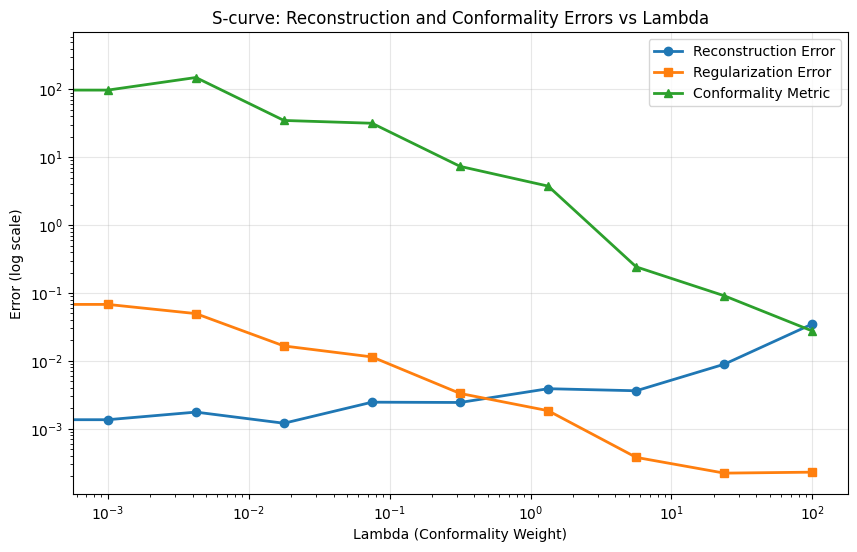

In [11]:
# Plot error curves
plt.figure(figsize=(10, 6))
plt.plot(lambda_isos, recon_errors, 'o-', label='Reconstruction Error', linewidth=2)
plt.plot(lambda_isos, regularization_errors, 's-', label='Regularization Error', linewidth=2)
plt.plot(lambda_isos, reg_metrics, '^-', label='Conformality Metric', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lambda (Conformality Weight)')
plt.ylabel('Error (log scale)')
plt.title('S-curve: Reconstruction and Conformality Errors vs Lambda')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Save results to CSV
results_df = pd.DataFrame({
    'lambda_conf': lambda_isos,
    'reconstruction_error': recon_errors,
    'regularization_error': regularization_errors,
    'conformality_metric': reg_metrics
})
results_df.to_csv(f"{dir_path}/results.csv", index=False)
print("Results saved to CSV")

Results saved to CSV


Model and custom variables loaded from models/conformal_autoencoder_cosine_comp_scurve/lambda_0.000_model_1.pth


TypeError: Axes.scatter() got multiple values for argument 's'

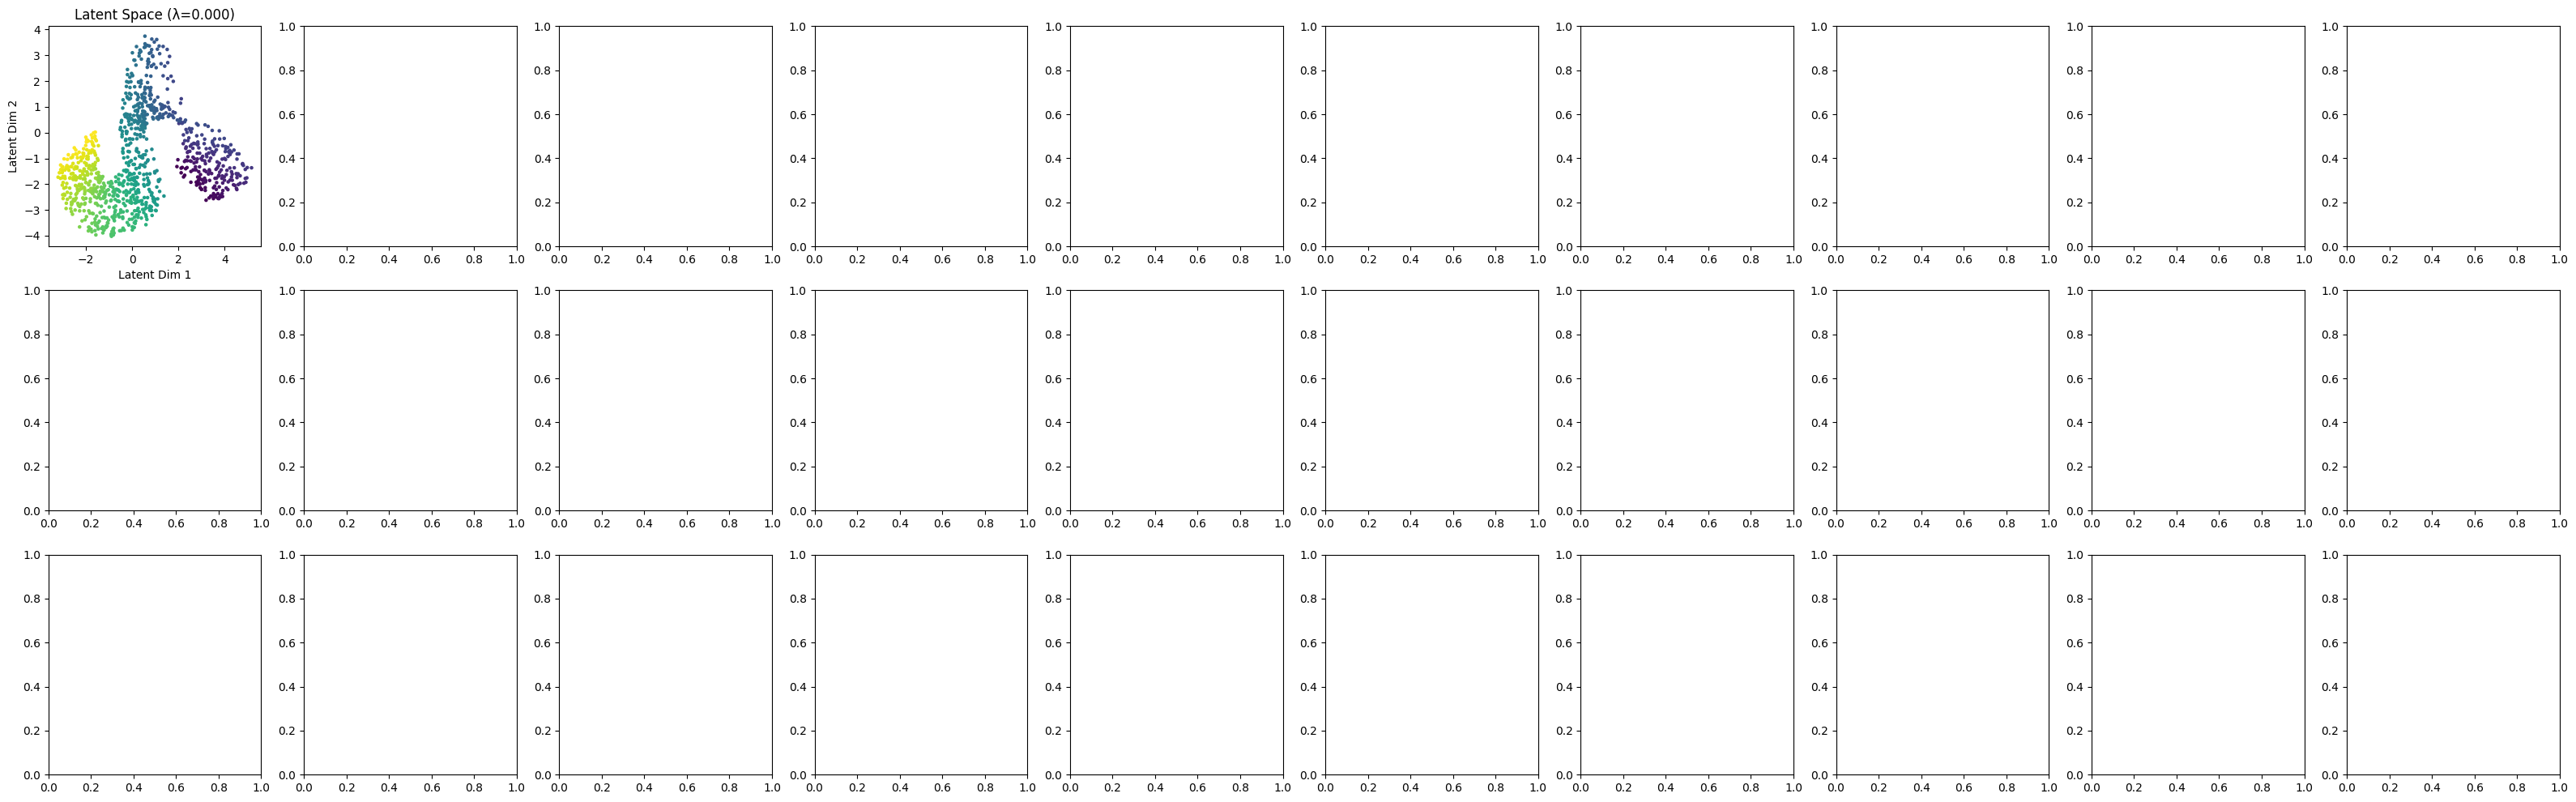

In [13]:
# Visualize latent representations and reconstructions
fig, axs = plt.subplots(3, len(lambda_isos), figsize=(4*len(lambda_isos), 12))

for i, lambda_iso in enumerate(lambda_isos):
    # Load a trained model
    model_path = modelpath(dir_path, lambda_iso, 0)  # Use first model
    encoder = Encoder(input_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, output_dim).to(device)
    model = ConformalAutoencoder(encoder, decoder, lambda_conf=lambda_iso).to(device)
    model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    # Plot latent space (2D)
    axs[0, i].scatter(encoded_data[:, 0].cpu(), encoded_data[:, 1].cpu(), 
                     c=val_labels, s=5, cmap='viridis')
    axs[0, i].set_title(f'Latent Space (λ={lambda_iso:.3f})')
    axs[0, i].set_xlabel('Latent Dim 1')
    axs[0, i].set_ylabel('Latent Dim 2')
    
    # Plot original data (3D)
    if len(lambda_isos) <= 5:  # Only for smaller number of subplots
        axs[1, i] = fig.add_subplot(3, len(lambda_isos), 2*len(lambda_isos) + i + 1, projection='3d')
    axs[1, i].scatter(val_data[:, 0].cpu(), val_data[:, 1].cpu(), val_data[:, 2].cpu(), 
                     c=val_labels, s=5, cmap='viridis')
    axs[1, i].set_title(f'Original S-curve')
    
    # Plot reconstruction (3D)
    if len(lambda_isos) <= 5:  # Only for smaller number of subplots
        axs[2, i] = fig.add_subplot(3, len(lambda_isos), 3*len(lambda_isos) + i + 1, projection='3d')
    axs[2, i].scatter(reconstruction[:, 0].cpu(), reconstruction[:, 1].cpu(), reconstruction[:, 2].cpu(), 
                     c=val_labels, s=5, cmap='viridis')
    axs[2, i].set_title(f'Reconstruction (λ={lambda_iso:.3f})')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze conformality with trace visualization
fig, axs = plt.subplots(2, min(5, len(lambda_isos)), figsize=(20, 8))
if len(lambda_isos) == 1:
    axs = axs.reshape(2, 1)

for i, lambda_iso in enumerate(lambda_isos[:5]):  # Limit to first 5 for visibility
    # Load model
    model_path = modelpath(dir_path, lambda_iso, 0)
    encoder = Encoder(input_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, output_dim).to(device)
    model = ConformalAutoencoder(encoder, decoder, lambda_conf=lambda_iso).to(device)
    model.load_model_from_checkpoint(model_path)
    
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data)
        reconstruction = model.decode(encoded_data)

    # Compute conformality traces
    trace_vals = np.zeros_like(encoded_data[:, 0].cpu())
    for j, z in enumerate(encoded_data[:100]):  # Limit for computational efficiency
        z = z.unsqueeze(0)  # Add batch dimension
        
        # Compute the Jacobian J of the decoder at point z
        J = torch.autograd.functional.jacobian(model.decode, z)[0, :, 0, :]
        
        # Compute the trace of J^T J
        JtJ = J.T @ J
        trace_JtJ = torch.trace(JtJ)
        
        # Store the normalized trace value
        trace_vals[j] = trace_JtJ.item() / JtJ.shape[0]

    # Plot latent space colored by conformality
    scatter = axs[0, i].scatter(encoded_data[:100, 0].cpu(), encoded_data[:100, 1].cpu(), 
                               c=trace_vals[:100], s=20, cmap='coolwarm')
    axs[0, i].set_title(f'Latent Space - Conformality\n(λ={lambda_iso:.3f})')
    axs[0, i].set_xlabel('Latent Dim 1')
    axs[0, i].set_ylabel('Latent Dim 2')
    plt.colorbar(scatter, ax=axs[0, i])
    
    # Plot reconstruction colored by conformality
    if axs.ndim > 1:
        ax_3d = fig.add_subplot(2, min(5, len(lambda_isos)), min(5, len(lambda_isos)) + i + 1, projection='3d')
    else:
        ax_3d = fig.add_subplot(2, 1, 2, projection='3d')
    
    scatter_3d = ax_3d.scatter(reconstruction[:100, 0].cpu(), reconstruction[:100, 1].cpu(), 
                              reconstruction[:100, 2].cpu(), c=trace_vals[:100], s=20, cmap='coolwarm')
    ax_3d.set_title(f'Reconstruction - Conformality\n(λ={lambda_iso:.3f})')
    plt.colorbar(scatter_3d, ax=ax_3d, shrink=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# Comprehensive conformality evaluation
statses = []
for i, lambda_iso in enumerate(lambda_isos):
    model_path = modelpath(dir_path, lambda_iso, 0)
    encoder = Encoder(input_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, output_dim).to(device)
    model = ConformalAutoencoder(encoder, decoder, lambda_conf=lambda_iso).to(device)
    model.load_model_from_checkpoint(model_path)
    
    model.eval()
    stats = evaluate_conformality(model, val_data, double_precision=True)
    statses.append(stats)
    print(f"Lambda {lambda_iso:.3f} - Lambda mean: {stats['lambda_mean']:.4f}, std: {stats['lambda_std']:.4f}")

# Create comprehensive results DataFrame
df = pd.DataFrame(statses, index=[f"{λ:.3f}" for λ in lambda_isos])
print("\nConformality Analysis Complete")

In [ ]:
# Style the results DataFrame for better visualization
styled_df = df.style \
    .background_gradient(subset=[
            'reconstruction_error',
            'diagonal_gini',
            'lambda_std',
            'lambda_std_normed',
            'off_diag_mean',
            'off_diag_norm',
            'off_diag_mean_normed',
            'off_diag_norm_normed',
            'jTj_minus_lambdaI_mean',
            'jTj_minus_lambdaI_norm',
            'jTj_minus_lambdaI_mean_normed',
            'jTj_minus_lambdaI_norm_normed',
            'determinant_vs_estimate_std',
            ], cmap='Reds') \
    .background_gradient(subset=[
        'determinant_vs_estimate_mean'
    ], cmap='Greens') \
    .background_gradient(subset=[
        'lambda_mean',
        'latent_std',
        'latent_std_max',
        'latent_std_min',
        'latent_norm',
    ], cmap='Blues') \
    .format(precision=4)

styled_df